In [17]:
from dataclasses import dataclass
from typing import Literal
from random import uniform
import numpy as np

In [18]:
@dataclass
class Node:
    val: float
    conn_weight: list
    epoch_data: list = None
    pre_activation: float = 0

class Network:
    def __init__(self):
        super().__init__()
        self.layers = []
        self.bias = 0

    def create_layer(self, nodes_count: int, layer_name: Literal["input", "hidden", "output"] = "hidden"):
        nodes = []
        for i in range(nodes_count):
            node = Node(uniform(0.5, 1), [])
            nodes.append(node)
        layer = {"name": layer_name, "nodes": nodes}
        self.layers.append(layer)

    def get_layer(self, layer_name: Literal["input", "hidden", "output"] = "hidden"):
        return [layer for layer in self.layers if layer['name'] == layer_name]

    def forward_propagate(self):
        input_layer = self.get_layer("input")[0]
        hidden_layers = self.get_layer("hidden")
        output_layer = self.get_layer("output")[0]

        hidden_layer = hidden_layers[0] if hidden_layers else None

        for h_index, h_node in enumerate(hidden_layer['nodes']):
            total_input = 0
            for i_index, i_node in enumerate(input_layer['nodes']):
                weight = i_node.conn_weight[h_index]
                total_input += i_node.val * weight
            h_node.pre_activation = total_input + self.bias
            h_node.val = self.relu(h_node.pre_activation)

        for o_index, o_node in enumerate(output_layer['nodes']):
            total_output = 0
            for h_index, h_node in enumerate(hidden_layer['nodes']):
                weight = h_node.conn_weight[o_index]
                total_output += h_node.val * weight
            o_node.pre_activation = total_output + self.bias
            o_node.val = o_node.pre_activation

    def adjust_network(self):
        for i in range(len(self.layers) - 1):
            current_layer = self.layers[i]
            next_layer = self.layers[i + 1]
    
            num_nodes_current = len(current_layer['nodes'])
            num_nodes_next = len(next_layer['nodes'])
    
            for node in current_layer['nodes']:
                node.conn_weight = [uniform(-0.5, 0.5) for _ in range(num_nodes_next)]


    def relu(self, x):
        return max(0, x)

    def predict(self, input_vals):
        for i, val in enumerate(input_vals):
            self.layers[0]['nodes'][i].val = val
        self.forward_propagate()
        output_layer = self.get_layer("output")[0]
        outputs = [node.val for node in output_layer['nodes']]
        return np.argmax(outputs), outputs

    def calc_mse(self, actual, predicted):
        mse = 0.5 * sum((a - p) ** 2 for a, p in zip(actual, predicted))
        return mse


    def calc_derivatives(self, loss, actual, predicted):
        d_loss = 2 * (predicted - actual)
        
    def backward_propagate(self, actual_outputs):
        # Get layers
        input_layer = self.get_layer("input")[0]
        hidden_layer = self.get_layer("hidden")[0]
        output_layer = self.get_layer("output")[0]
    
        # Calculate delta for output nodes (since output is linear, derivative of activation = 1)
        for i, o_node in enumerate(output_layer['nodes']):
            error = o_node.val - actual_outputs[i]
            o_node.delta = error  # dL/dz = (predicted - actual) for MSE
    
        # Calculate delta for hidden nodes
        for i, h_node in enumerate(hidden_layer['nodes']):
            downstream_gradient = 0
            for j, o_node in enumerate(output_layer['nodes']):
                downstream_gradient += o_node.delta * h_node.conn_weight[j]
            # Derivative of ReLU
            relu_derivative = 1 if h_node.pre_activation > 0 else 0
            h_node.delta = downstream_gradient * relu_derivative
    
        # Update weights from hidden to output layer
        learning_rate = 0.01
        for h_node in hidden_layer['nodes']:
            for j, o_node in enumerate(output_layer['nodes']):
                grad = o_node.delta * h_node.val  # dL/dw
                h_node.conn_weight[j] -= learning_rate * grad
    
        # Update weights from input to hidden layer
        for i_node in input_layer['nodes']:
            for j, h_node in enumerate(hidden_layer['nodes']):
                grad = h_node.delta * i_node.val
                i_node.conn_weight[j] -= learning_rate * grad
    
        # Optionally update bias terms if you want
        self.bias -= learning_rate * sum(o_node.delta for o_node in output_layer['nodes'])

    def train(self, X_train, y_train, epochs=10, verbose=True):
        loss_vals = []
        for epoch in range(epochs):
            export_to_csv(self, f"epoch_{epoch}.csv")
            total_loss = 0
            for i in range(len(X_train)):
                x = X_train[i]
                y_true = y_train[i]  # assumed to be one-hot encoded
    
                pred_class, output = self.predict(x)
                loss = self.calc_mse(y_true, output)
                total_loss += loss
                loss_vals.append(loss)
    
                self.backward_propagate(y_true)
    
            if verbose:
                avg_loss = total_loss / len(X_train)
                print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}")
        return loss_vals

In [19]:
def export_to_csv(network: Network, filename: str):
    # only accounts for neurons and it's values i.e weight for each connection and value
    data = []
    input_layer = network.get_layer("input")[0]
    hidden_layer = network.get_layer("hidden")[0]
    output_layer = network.get_layer("output")[0]

    node_ids = []
    node_vals = []
    node_weights = []

    for node_idx, node in enumerate(input_layer['nodes']):
        float_weights = [float(weight) for weight in node.conn_weight]
        
        node_ids.append(f"i{node_idx}")
        node_vals.append(node.val)
        node_weights.append(float_weights)

    data = {
        "node_id": node_ids,
        "node_val": node_vals,
        "node_weights": node_weights
    }

    data_df = pd.DataFrame.from_dict(data)
    data_df.to_csv(filename, index=False)


## Setting Up Data

In [20]:
# !source env/bin/activate
# !pip3 install pandas
# !pip3 install scikit-learn

In [45]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [46]:
digits = load_digits()
X = digits.data / 16.0  # normalize inputs (0–1)
y = digits.target.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2)

In [47]:
net = Network()
net.create_layer(64, "input")
net.create_layer(32, "hidden")
net.create_layer(10, "output")
net.adjust_network()

In [67]:
train_info = net.train(X_train, y_train, 10) # Cleared cell output for concise PDF

Epoch 1/10 - Avg Loss: 0.0703
Epoch 2/10 - Avg Loss: 0.0687
Epoch 3/10 - Avg Loss: 0.0672
Epoch 4/10 - Avg Loss: 0.0656
Epoch 5/10 - Avg Loss: 0.0639
Epoch 6/10 - Avg Loss: 0.0619
Epoch 7/10 - Avg Loss: 0.0597
Epoch 8/10 - Avg Loss: 0.0573
Epoch 9/10 - Avg Loss: 0.0550
Epoch 10/10 - Avg Loss: 0.0532


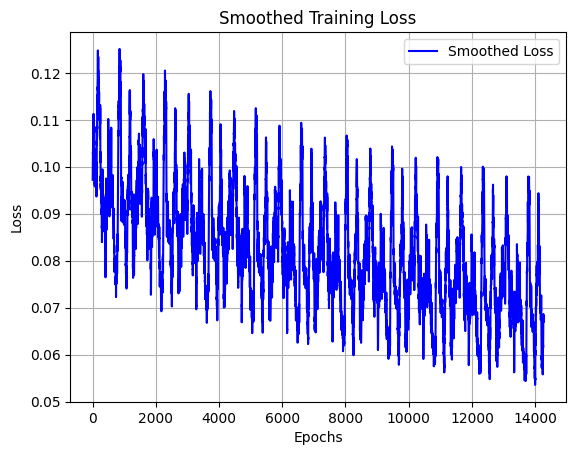

In [65]:
window_size = 100
smoothed_loss = np.convolve(train_info, np.ones(window_size)/window_size, mode='valid')

plt.plot(smoothed_loss, color='blue', label='Smoothed Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Smoothed Training Loss")
plt.legend()
plt.grid(True)
plt.show()


In [66]:
correct = 0
total = len(X_test)

for i in range(total):
    x = X_test[i]
    y_true_class = np.argmax(y_test[i])  # get actual class
    pred_class, _ = net.predict(x)
    
    if pred_class == y_true_class:
        correct += 1

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 94.44%


## Test Model

Enter image index from test set (0 to 359):  5


Predicted: 6, Actual: 6


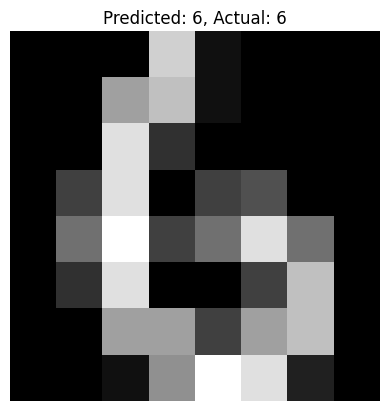

In [61]:
index = int(input("Enter image index from test set (0 to {}): ".format(len(X_test)-1)))

test_input = X_test[index]
true_label = np.argmax(y_test[index])

predicted_class, raw_outputs = net.predict(test_input)

print(f"Predicted: {predicted_class}, Actual: {true_label}")

plt.imshow(test_input.reshape(8, 8), cmap='gray')
plt.title(f"Predicted: {predicted_class}, Actual: {true_label}")
plt.axis('off')
plt.show()